# EIA Monthly Production by Basin

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from bs4 import BeautifulSoup as bs
import requests

## Web-scrape data release dates ##

In [61]:
def dpr_release_dates():
        """ web-scrape release dates of 
        most recent and upcoming production data update """
        base_url = 'https://www.eia.gov/petroleum/drilling/'
        response = requests.get(base_url)
        soup = bs(response.content, 'html.parser')
        release_div = soup.find("div",{"class":"release-dates"})
        for i in release_div:
                release_date = i.find_next('span').text
                if len(release_date) > 21:
                        print(release_date)
        print("Most recent Release includes EIA estimate data for the following month")
dpr_release_dates()


Release Date: August 15, 2022


Next Release Date: September 12, 2022

Most recent Release includes EIA estimate data for the following month


## Prep variables ##

In [41]:
url = 'https://www.eia.gov/petroleum/drilling/xls/dpr-data.xlsx'

sheets = ['Anadarko Region',
        'Permian Region',
        'Appalachia Region',
        'Bakken Region',
        'Eagle Ford Region',
        'Haynesville Region',
        'Niobrara Region']

# Read file, all sheets, into a dict
dict_all = pd.read_excel(url,
        sheet_name=sheets, engine='openpyxl',
        header=[0,1],
        parse_dates=True)

## Prep workbook - concatenate sheets & convert to DataFrame ##

In [42]:
for sheet in dict_all.keys():
    # add column for region, remove excess string
    dict_all[sheet][('', 'Region')] = sheet[:-7]
    # drop columns
    dict_all[sheet] = dict_all[sheet].drop(
                    [
                    ('Oil (bbl/d)', 'Production per rig'),
                    ('Oil (bbl/d)', 'Legacy production change'),
                    ('Natural gas (Mcf/d)', 'Production per rig'),
                    ('Natural gas (Mcf/d)', 'Legacy production change')
                    ],
                    axis=1)
    # rename columns
    dict_all[sheet].columns = dict_all[sheet].columns.to_flat_index()
    dict_all[sheet] = dict_all[sheet].rename(columns={
                                                (sheet, 'Month'):('', 'date'),
                                                ('Oil (bbl/d)', 'Total production'):('', 'crude production (bbl/d)'),
                                                ('Natural gas (Mcf/d)', 'Total production'):('', 'gas production (mcf/d)')
                                                })
    dict_all[sheet].columns = pd.MultiIndex.from_tuples(dict_all[sheet].columns)
    # convert MultiIndex columns to single index
    dict_all[sheet] = dict_all[sheet].droplevel(0,axis=1)

In [43]:
# concatenate sheets into DataFrame
df = pd.concat(dict_all, ignore_index=True)

# add year and month columns
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

# convert timestamp to object to remove timestamp in pivot table analysis
df['date'] = pd.to_datetime(df['date']).dt.date

## Charting and analysis  ##

In [44]:
sns.set_theme(style="darkgrid")

### Monthly crude production by basin ###

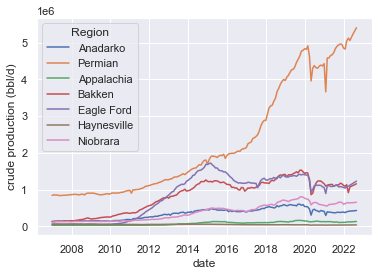

In [45]:
sns.lineplot(data=df, x='date', y='crude production (bbl/d)', hue='Region', ci=None)
plt.show()

### Latest month's production and changes ###

In [46]:
# pull latest 2 months and prior year month of data
df_comp_months = df[(df['date'] == df['date'].iloc[-1]) |
                      (df['date'] == df['date'].iloc[-2]) |
                      (df['date'] == df['date'].iloc[-13])]
# create pivot table
pivot = pd.pivot_table(data=df_comp_months,
                       index=['Region'],
                       columns=['date'],
                       values='crude production (bbl/d)',
                       aggfunc='mean')
# clean and sort
pivot = pivot.astype(int).round()
pivot = pivot.sort_values(by=df['date'].iloc[-1], ascending=False)
# add summary columns
pivot['MoM change'] = pivot.iloc[:,2] - pivot.iloc[:,1]
pivot['MoM pct change'] = (((pivot.iloc[:,2] / pivot.iloc[:,1]) - 1) * 100).round(2).astype(str) + '%'
pivot['YoY change'] = pivot.iloc[:,2] - pivot.iloc[:,0]
pivot['YoY pct change'] = (((pivot.iloc[:,2] / pivot.iloc[:,0]) - 1) * 100).round(2).astype(str) + '%'

In [59]:
def show_summary():
        """ show pivot table summary data"""
        dpr_release_dates()
        print("\n----- Units in barrels per day (bbl/d) -----")
        return pivot
show_summary()


Release Date: August 15, 2022


Next Release Date: September 12, 2022

Most recent Release includes EIA estimate data for the following month

----- Units in barrels per day (bbl/d) -----


date,2021-09-01,2022-08-01,2022-09-01,MoM change,MoM pct change,YoY change,YoY pct change
Region,,,,,,,
Permian,4904169,5329306,5408152,78846,1.48%,503983,10.28%
Eagle Ford,1119485,1204439,1230497,26058,2.16%,111012,9.92%
Bakken,1127709,1136659,1157151,20492,1.8%,29442,2.61%
Niobrara,626620,648764,654850,6086,0.94%,28230,4.51%
Anadarko,381619,424669,430500,5831,1.37%,48881,12.81%
Appalachia,117000,127708,130948,3240,2.54%,13948,11.92%
Haynesville,33674,36649,37012,363,0.99%,3338,9.91%


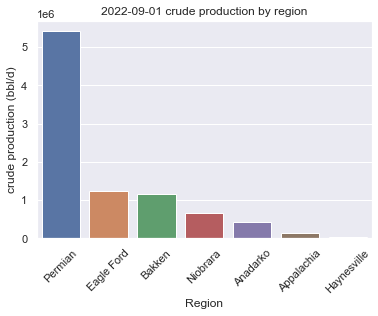

In [48]:
# latest month production across all basins
df_latest_month = df_comp_months[df_comp_months['date'] == df_comp_months['date'].max()]
df_latest_month = df_latest_month.sort_values(by=['crude production (bbl/d)'], ascending=False)
sns.barplot(x='Region', y='crude production (bbl/d)', data=df_latest_month).set(title=str(df_comp_months['date'].max()) + ' crude production by region')
plt.xticks(rotation=45)
plt.show()

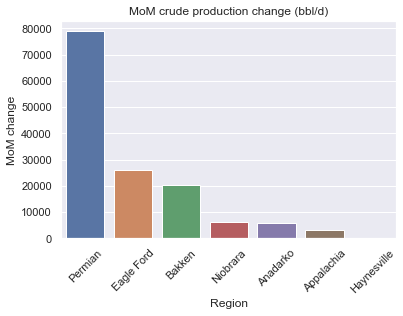

In [49]:
# MoM bbl change across all regions, sorted
sns.barplot(x=pivot.index, y='MoM change', data=pivot).set(title= 'MoM crude production change (bbl/d)')
plt.xticks(rotation=45)
plt.show()

### Top 2 producing regions in the latest full year ###

In [50]:
# get latest full year of production data: latest_year
if df['date'].max().month == 12:
    latest_year = df['year'].max()
else:
    latest_year = df['year'].max() - 1

# dataframe of yearly production by region
df_yearly_prod = df.groupby(['Region', 'year'])['crude production (bbl/d)'].mean().reset_index()

# subset yearly production dataframe to get last 2 years for analysis
df_oil_prod_latest_year = df_yearly_prod[df_yearly_prod['year'] == latest_year].sort_values('crude production (bbl/d)', ascending=False)
df_oil_prod_prior_year = df_yearly_prod[df_yearly_prod['year'] == latest_year - 1].sort_values('crude production (bbl/d)', ascending=False)
# pull production levels from prior year based on above subsets
current_top_producer_prior_year = df_oil_prod_prior_year[df_oil_prod_prior_year['Region'] == df_oil_prod_latest_year.iloc[0][0]]['crude production (bbl/d)'].item()
second_top_producer_prior_year = df_oil_prod_prior_year[df_oil_prod_prior_year['Region'] == df_oil_prod_latest_year.iloc[1][0]]['crude production (bbl/d)'].item()
# analyze YoY changes for top 2 producing regions
top_inc_dec = df_oil_prod_latest_year.iloc[0][2] - current_top_producer_prior_year
second_inc_dec = df_oil_prod_latest_year.iloc[1][2] - second_top_producer_prior_year

In [51]:
print('\nIn ' + str(latest_year) + ', ' + df_oil_prod_latest_year.iloc[0][0] + ' was the largest oil producing basin in the US, pumping ' +
        "{0:.3g}".format(df_oil_prod_latest_year.iloc[0][2]) + ' bbls/d.')

print('------ Production in the basin changed by ' +
        "{:.0%}".format(df_oil_prod_latest_year.iloc[0][2] / current_top_producer_prior_year - 1) + 
        ', or ' + "{0:.3g}".format(top_inc_dec) + ' bbls/d compared to ' + str(latest_year - 1) + '------\n')


print('The 2nd largest producing region, ' + df_oil_prod_latest_year.iloc[1][0] + ', pumped ' +
        "{0:.3g}".format(df_oil_prod_latest_year.iloc[1][2]) + 'bbls/d.')

print('------ Production in the basin changed by ' +
        "{:.0%}".format(df_oil_prod_latest_year.iloc[1][2] / second_top_producer_prior_year - 1) + 
        ', or ' + "{0:.3g}".format(second_inc_dec) + ' bbls/d compared to ' + str(latest_year - 1) + '------')


In 2021, Permian was the largest oil producing basin in the US, pumping 4.66e+06 bbls/d.
------ Production in the basin changed by 4%, or 1.95e+05 bbls/d compared to 2020------

The 2nd largest producing region, Bakken, pumped 1.13e+06bbls/d.
------ Production in the basin changed by -6%, or -7.38e+04 bbls/d compared to 2020------
